# Project:  Food - Wine
## Path: start2impact University Master Data Science Course 4 Machine Learning
## Author: Giacomo Abramo

# WINE DATASET ANALYSIS

**This work refers to a dataset that contains the results of the chemical analysis of wines produced by three different Italian growers. 
The aim is to understand the type of wine starting from its chemical values. We are therefore within the supervised learning field and we are faced with a classification problem**

In [1]:
# let's import libraries, functions, classes and the dataset

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from typing import Optional
from sklearn.datasets import load_wine
from scipy import stats
from scipy.stats import skew
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import levene
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report


import warnings
import logging

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.WARNING, format="%(levelname)s:%(message)s")

In [2]:
# let's define some functions we'll use


def check_duplicate_rows(df: pd.DataFrame) -> Optional[bool]:

    if df.empty:
        logging.info("The DataFrame is empty.")
        return None

    duplicate_rows = df[df.duplicated()]

    if not duplicate_rows.empty:
        logging.warning("There are duplicate rows in the DataFrame.")

        print("There are duplicate rows in the dataframe:")
        print(duplicate_rows)
        return True
    else:
        print("There are NO duplicate rows in the dataframe.")
        return False
    
    
def kolmogorov_smirnov_test(X_train, X_test, alpha=0.05):
    p_values = []
    for col in X_train.columns:
        statistic, p_value = ks_2samp(X_train[col], X_test[col])
        p_values.append(p_value)
    
    for col, p_value in zip(X_train.columns, p_values):
        if p_value > alpha:
            print(f"Not enough evidence to reject the null hypothesis for column {col}.")
        else:
            print(f"Reject the null hypothesis for column {col}, the two samples do not come from the same distribution.")
            
            
def shapiro_wilk_test(X_train, alpha=0.05):
    p_values = []
    for col in X_train.columns:
        statistic, p_value = shapiro(X_train[col])
        p_values.append(p_value)
    
    for col, p_value in zip(X_train.columns, p_values):
        if p_value > alpha:
            print(f"Not enough evidence to reject the null hypothesis for {col}.")
        else:
            print(f"Reject the null hypothesis for column {col}. The variable is not normally distributed")
            
            
            
def anova_correlation(dataframe_numeric, dataframe_categorical, alpha=0.05):
    for column in dataframe_numeric.columns:
        f_statistic, p_value = f_oneway(dataframe_numeric[column], dataframe_categorical)
        if p_value > alpha:
            print(f"No sufficient evidence to reject the null hypothesis for {column}.")
        else:
            print(f"Reject the null hypothesis for column {column}. There is a significant difference in means.")
            
            
def check_homoscedasticity(dataframe_numeric, dataframe_categorical, alpha=0.05):
    for column in dataframe_numeric.columns:
        statistic, p_value = levene(dataframe_numeric[column], dataframe_categorical)
        
        if p_value > alpha:
            print(f"Not enough evidence to reject the null hypothesis for {column}. Homoscedasticity assumption is met.")
        else:
            print(f"Reject the null hypothesis for {column}. Homoscedasticity assumption is violated.")

    

def evaluate_skewness(dataframe):

    skewness = dataframe.apply(skew)

    skewness_evaluation = pd.DataFrame(columns=["Variable", "Skewness", "Evaluation"])
    for column, value in skewness.items():
        if value >= -0.5 and value <= 0.5:
            evaluation = "Approximately symmetric"
        elif (value >= -1 and value < -0.5) or (value > 0.5 and value <= 1):
            evaluation = "Moderately skewed"
        else:
            evaluation = "Strongly skewed"

        skewness_evaluation = skewness_evaluation.append(
            {"Variable": column, "Skewness": value, "Evaluation": evaluation},
            ignore_index=True,
        )

    return skewness_evaluation


def apply_power_transformation(dataframe, original_df):
    moderately_skewed_vars = dataframe[dataframe["Evaluation"].isin(["Moderately skewed", "Strongly skewed"])]
    
    transformed_skewness = pd.DataFrame(columns=["Variable", "Skewness_before_pt", "Skewness_after_pt", "Evaluation"])
    for index, row in moderately_skewed_vars.iterrows():
        var = row["Variable"]
        pt = PowerTransformer(method='yeo-johnson')
        transformed_data = pt.fit_transform(original_df[[var]])
        skewness_before = skew(original_df[var])
        skewness_after = skew(transformed_data)
        
        if skewness_after >= -0.5 and skewness_after <= 0.5:
            evaluation = "Approximately symmetric"
        elif (skewness_after >= -1 and skewness_after < -0.5) or (skewness_after > 0.5 and skewness_after <= 1):
            evaluation = "Moderately skewed"
        else:
            evaluation = "Strongly skewed"
            
        transformed_skewness = transformed_skewness.append(
            {"Variable": var, "Skewness_before_pt": skewness_before, "Skewness_after_pt": skewness_after[0], "Evaluation": evaluation},
            ignore_index=True,
        )
    

    transformed_skewness = transformed_skewness[["Variable", "Skewness_before_pt", "Skewness_after_pt", "Evaluation"]]
    
    return transformed_skewness




def create_preprocessor(columns, apply_yeo_johnson=True):
    transformers = [("scaler", StandardScaler(), list(range(columns.shape[1])))]
    if apply_yeo_johnson:
        transformers.append(
            (
                "Yeo-Johnson Transformation",
                PowerTransformer(standardize=True),
                [1, 4, 9, 12],
            )
        )
        # Includiamo remainder="passthrough" solo nel trasformatore di StandardScaler
        return ColumnTransformer(transformers=[("preprocessor", StandardScaler(), list(range(columns.shape[1])))],
                                 remainder="passthrough")
    else:
        return ColumnTransformer(transformers=transformers, remainder="passthrough")


def create_pipeline(preprocessor):
    return Pipeline([("preprocessor", preprocessor), ("classifier", knn)])


def perform_grid_search(pipeline, param_grid, X, y):
    loo = LeaveOneOut()
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=loo,
        n_jobs=-1,
        scoring="accuracy",
    )
    grid_search.fit(X, y)
    return grid_search

In [3]:
# let's define the dataset in pandas

wine = load_wine()

df = pd.DataFrame(wine["data"], columns=wine["feature_names"])
df["target"] = wine["target"]

# BRIEF ANALYSIS OF THE DATASET

In [4]:
# let's take a first look at the dataset

df.head()

# Visualizing the first five rows and the columns we can better understand the problem

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0

In [5]:
# let's take a look at the structure of the dataset

df.info()
print("\n")
check_duplicate_rows(df)


# There are no missing values; the type of values is consistent with each variable except with target; there are no duplicates.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

False

In [6]:
df.target = df.target.astype("category")

# Changing the pandas Dtype of the target variable from int32 to category allows us to have a correct interpretation of the target variable. 
# Furthermore, although it is the target variable (and therefore the Dtype does not directly influence the model calculation operations as in the case of features) a small advantage is still obtained in terms of memory reduction.

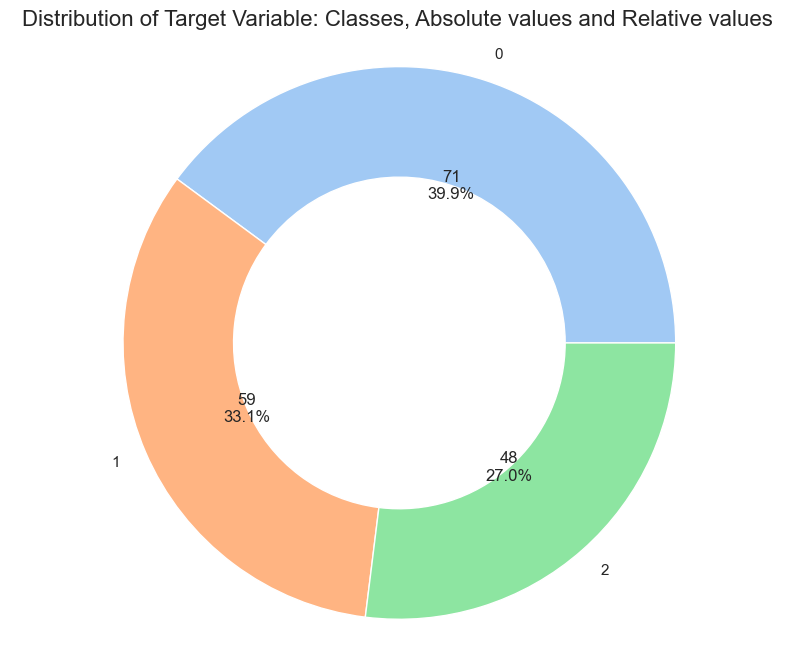

In [7]:
# let's take a look at the composition of the Target Variable

target_counts = df["target"].value_counts()
target_percentages = df["target"].value_counts(normalize=True)


class_names = df["target"].unique()


sns.set(style="whitegrid")


plt.figure(figsize=(10, 8))


patches, texts, autotexts = plt.pie(
    target_counts,
    labels=class_names,
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel"),
    wedgeprops=dict(width=0.4),
)


for autotext, value in zip(autotexts, target_counts):
    autotext.set_text(f"{value}\n{autotext.get_text()}")


plt.title(
    "Distribution of Target Variable: Classes, Absolute values and Relative values",
    fontsize=16,
)


plt.axis("equal")
plt.show()



**Target Variable appears equally distributed among the classes:<br>**
**1) We don't need of Undersampling/Oversampling methods or others unbalanced solved techniques<br>**
**2) Accuracy can be a good metric for the model evaluation<br>**

# BASELINE MODEL

**At this stage we can also have a FIRST idea on which predictive algorithm to choose.**


**At the moment my choice is KNN Classifier. Why?**

**The KNN Classifier has the advantage of being a very simple but very powerful classifier. Its main weakness is the possibility of being very slow. In the dataset under consideration, however, given the limited number of samples and features, this weakness should not emerge.**

In [8]:
# We realize a train-test split based on train and test sets similarity with a Kolmogorov-Smirnov approach.
# This approach allows us to determine whether the train and test sets can be considered as samples drawn from the same population

X = df.drop(["target"], axis=1)
y = df["target"]

n_features = X.shape[1]

n_tries = 500

result = []

for random_state in range(n_tries):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
    distances = list(
        map(
            lambda i: ks_2samp(X_train.iloc[:, i], X_test.iloc[:, i]).statistic,
            range(n_features),
        )
    )
    result.append((random_state, max(distances)))

result.sort(key=lambda x: x[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=result[0][0])

In [9]:
# Let's check if this split passes the Kolmogorov-Sminorv test.
# The null hypothesis (Ho) is that the two dataset values come from the same distribution. 
# The alternative hypothesis (H1) is that these two datasets values come from different distributions. 

kolmogorov_smirnov_test(X_train, X_test)

# This split passes the test. 

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

Not enough evidence to reject the null hypothesis for column alcohol.
Not enough evidence to reject the null hypothesis for column malic_acid.
Not enough evidence to reject the null hypothesis for column ash.
Not enough evidence to reject the null hypothesis for column alcalinity_of_ash.
Not enough evidence to reject the null hypothesis for column magnesium.
Not enough evidence to reject the null hypothesis for column total_phenols.
Not enough evidence to reject the null hypothesis for column flavanoids.
Not enough evidence to reject the null hypothesis for column nonflavanoid_phenols.
Not enough evidence to reject the null hypothesis for column proanthocyanins.
Not enough evidence to reject the null hypothesis for column color_intensity.
Not enough evidence to reject the null hypothesis for column hue.
Not enough evidence to reject the null hypothesis for column od280/od315_of_diluted_wines.
Not enough evidence to reject the null hypothesis for column proline.


*Kolmogorov-smirnov test has three underlying assumptions:<br>*
*1) The two samples are mutually independent;<br>*
*2) The scale of measurement is at least ordinal;<br>*
*3) The test is only exact for continuous variables; it is conservative for discrete variables.*

These three assumptions are satisfied 

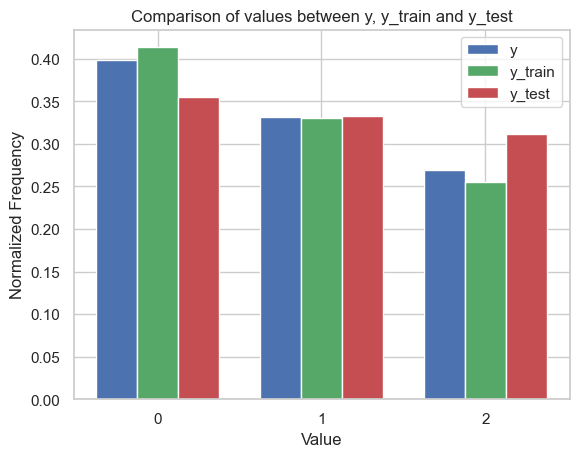

In [10]:
# We verify the implication in the target variable

labels = y.unique()
y_counts = y.value_counts(normalize=True)
y_train_counts = y_train.value_counts(normalize=True)
y_test_counts = y_test.value_counts(normalize=True)


bar_width = 0.25


indices = np.arange(len(labels))


plt.bar(indices, y_counts, width=bar_width, color="b", label="y")
plt.bar(indices + bar_width, y_train_counts, width=bar_width, color="g", label="y_train")
plt.bar(indices + 2 * bar_width, y_test_counts, width=bar_width, color="r", label="y_test")


plt.xlabel("Value")
plt.ylabel("Normalized Frequency")
plt.title("Comparison of values between y, y_train and y_test")


plt.xticks(indices + bar_width, labels)


plt.legend()


plt.show()

# the distribution of target variable in y_train and y_test appears reflect the distribution of y

In [11]:
# Let's check the behavior of the classificator chosen without pre-processing and hyperparameter-tuning

knn = KNeighborsClassifier(n_jobs=-1) # n_jobs cannot be considered as a real hyperparameter (it doesn’t affect fit method)
knn.fit(X_train, y_train)
knn.score(X_test, y_test).round(2)

0.58

**This accuracy value allows us to assert that our model has certainly learned something. Let's imagine we didn't create the model; given a row, what would be the probability of guessing the correct target?**


**Considering that the three possible values have more or less the same probability of occurring (we deduce this by looking at the three red bars in the previous graph representing the distribution of y_test) we would say that this probability is around 0.33 (one over three) which is quite a bit lower than 0.58.**

**However, we will verify whether the predictive capacity of the model can be improved**


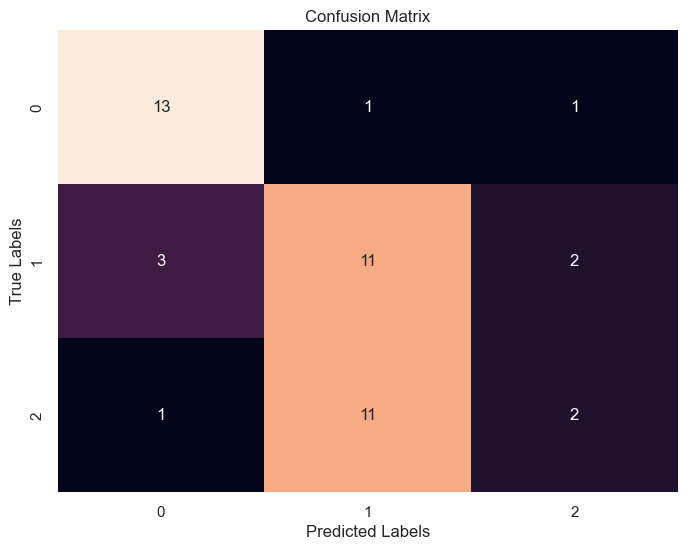

In [12]:
# Let's check where the model goes wrong

y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

**The biggest error is made in the prediction of class 2. Only 2 wines are correctly predicted**

**There are 12 wines that belong to class 2 but which are mistaken as belonging to other classes. The biggest error is related to class 1 (11 wines);**
**There are 3 wines predicted wrongly as belonging to class 2. The biggest error is related to class 1 (2 wines)**

**The model seems not to be able to distinguish mainly class 1 and class 2**

In [13]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.48      0.69      0.56        16
           2       0.40      0.14      0.21        14

    accuracy                           0.58        45
   macro avg       0.55      0.57      0.53        45
weighted avg       0.55      0.58      0.54        45



**The classification report show us the above analysis in terms of precision, recall and f1-score and it confirms what we said about class 2**

# EXPLORATORY DATA ANALYSIS

Let's check if EDA can help us to discover insight and problem in order to improve the prediction power of the model

In [14]:
# KNN Classifier alghoritm can be affected by outliers
# We use IsolationForest in order to detect outliers using default hyperparameters

iforest = IsolationForest(random_state=42)
prediction = iforest.fit_predict(X_train)

n_outliers = (prediction == -1).sum()
n_normals = (prediction == 1).sum()

print("Number of outliers detected: {}".format(n_outliers))
print("Number of normal samples detected: {}".format(n_normals))

X_train_nooutliers = X_train[prediction == 1]
y_train_nooutliers = y_train[prediction == 1]

Number of outliers detected: 12
Number of normal samples detected: 121


**This algorithm found some outliers, these could influence the performance of the model.**

In [15]:
# let's take a look at some statistical informations of each numerical variables

X_train.describe().round(2)

# the first thing that catches our attention is the diversity of value scales; especially for "proline" and "magnesio" variables.

alcohol  malic_acid     ash  alcalinity_of_ash  magnesium  \
count   133.00      133.00  133.00             133.00     133.00   
mean     12.98        2.33    2.37              19.57      99.77   
std       0.83        1.15    0.27               3.43      13.67   
min      11.03        0.74    1.36              10.60      70.00   
25%      12.33        1.57    2.21              17.40      88.00   
50%      13.05        1.83    2.36              19.50      98.00   
75%      13.67        3.10    2.56              21.50     110.00   
max      14.83        5.65    3.23              30.00     139.00   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count         133.00      133.00                133.00           133.00   
mean            2.32        2.06                  0.36             1.58   
std             0.63        1.02                  0.13             0.57   
min             0.98        0.34                  0.14             0.41   
25%             1.78        1.22                  0.26             1.25   
50%             2.36        2.19                  0.34             1.48   
75%             2.83        2.92                  0.43             1.97   
max             3.88        5.08                  0.66             3.58   

       color_intensity     hue  od280/od315_of_diluted_wines  proline  
count           133.00  133.00                        133.00   133.00  
mean              5.07    0.97                          2.62   750.30  
std               2.36    0.23                          0.71   327.87  
min               1.28    0.48                          1.27   278.00  
25%               3.05    0.79                          1.93   500.00  
50%               4.60    0.98                          2.78   672.00  
75%               6.38    1.12                          3.17   985.00  
max              11.75    1.71                          4.00  1680.00


### GIVEN THAT WE USED KNN ALGORITHM WE SHOULD TRY TO RESCALE VARIABLES

**In fact, different orders of magnitude between variables can influence the perceived importance of the KNN Classifier given that this algorithm is based on distances. Specifically, the KNN Classifier may "think" that the variables with the highest order of magnitude are more important than the others. This is a bias that must be avoided since the order of magnitude of a variable is not, in itself, a bearer of information or predictive power.**

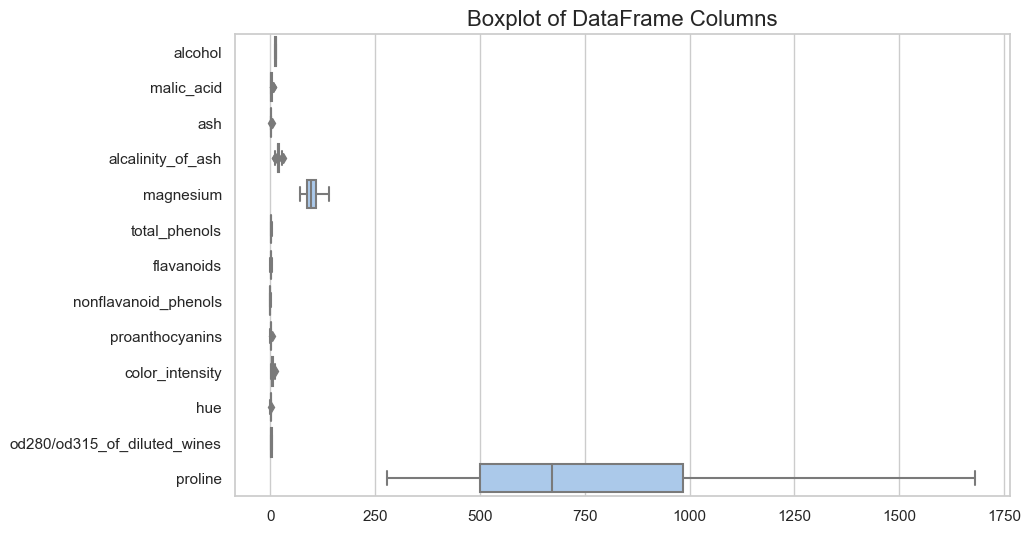

In [16]:
# let's take a look at the boxplot for a graphical confirm

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, orient="h", color=sns.color_palette("pastel")[0])


plt.title("Boxplot of DataFrame Columns", fontsize=16)

plt.show()

# This graph shows graphically the different scale. In addition, it can show us further informations like presence of outliers.

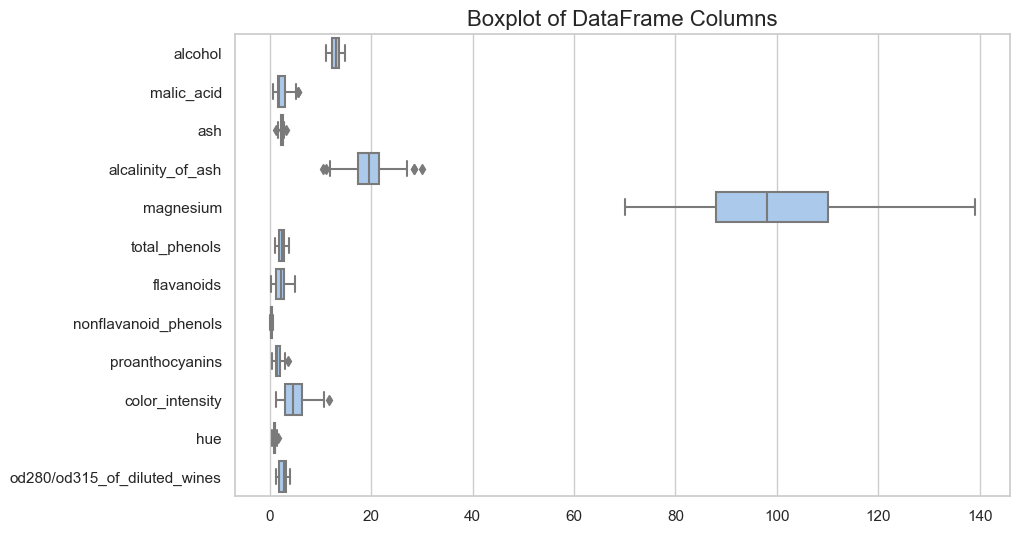

In [17]:
# Given the huge different relative the scale let's take a look at the boxplot without "proline" variable

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=X_train.drop("proline", axis=1), orient="h", color=sns.color_palette("pastel")[0]
)

plt.title("Boxplot of DataFrame Columns", fontsize=16)

plt.show()

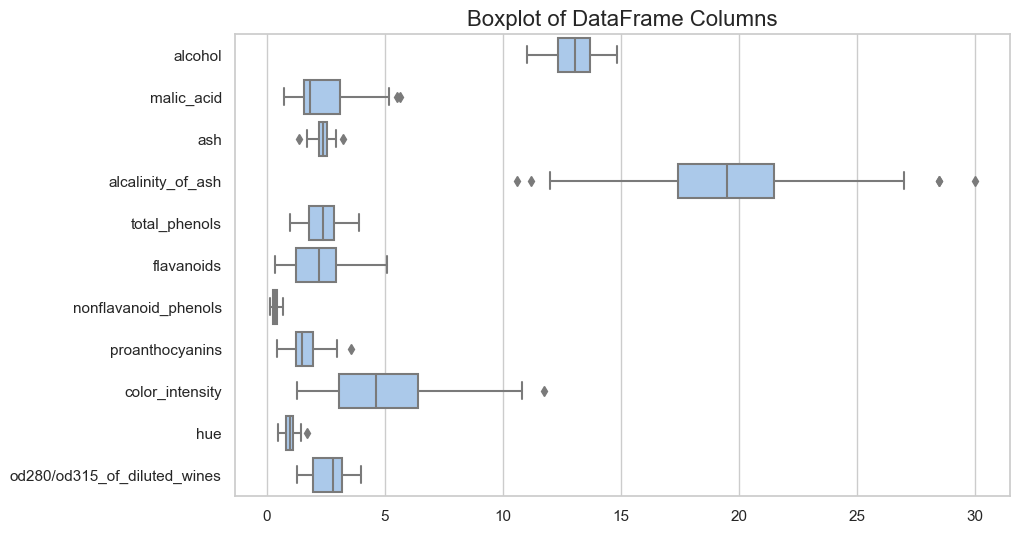

In [18]:
# For the same reason let's take a look at the boxplot without "magnesium" variable

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=X_train.drop(["proline", "magnesium"], axis=1),
    orient="h",
    color=sns.color_palette("pastel")[0],
)


plt.title("Boxplot of DataFrame Columns", fontsize=16)


plt.show()

# these plots, in addition to showing a different scale of values for the variables, also show us some outliers from an univariate point of view

**It's interesting to visualize impact of different scales of value. Let's consider the scatterplot between proline and one other variable in order to understand the problem deriving from different scale**

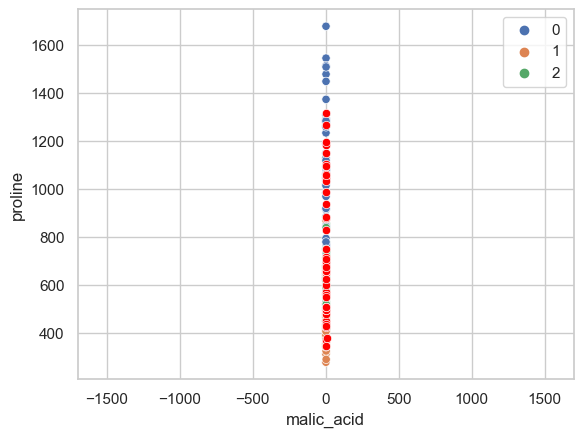

In [19]:
sns.scatterplot(data=train, x=train["malic_acid"], y=train["proline"], hue = y_train)
sns.scatterplot(data=test, x=test["malic_acid"], y=test["proline"], color="red")
plt.xlim(-1700, 1700)

plt.show()

# The graph below show us how proline values have a significantly greater importance in class assignment in the test dataset

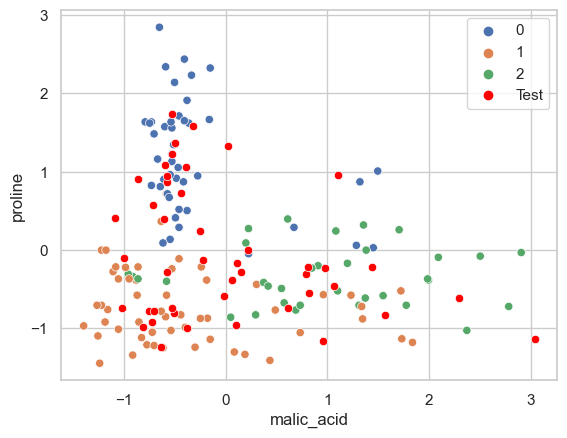

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns)
train_scaled = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)



X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X.columns)
test_scaled = pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis=1)
train_plot = sns.scatterplot(data=train_scaled, x="malic_acid", y="proline", hue=y_train.reset_index(drop=True))


test_plot = sns.scatterplot(data=test_scaled, x="malic_acid", y="proline", color="red")
handles_train, labels_train = train_plot.get_legend_handles_labels()
test_legend = plt.plot([], marker='o', markersize=6, color='red', linestyle='None', label='Test')[0]
plt.legend(handles=handles_train + [test_legend], labels=labels_train + ["Test"])
plt.show()

**The difference between the two scatter plot is evident. Scaling show us now how "proline" has the same importance of the other variables like "malic_acid".**

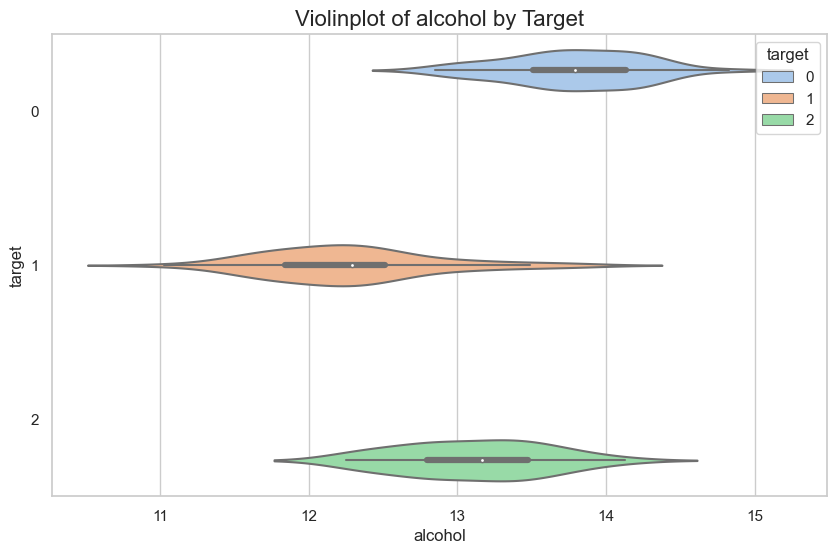

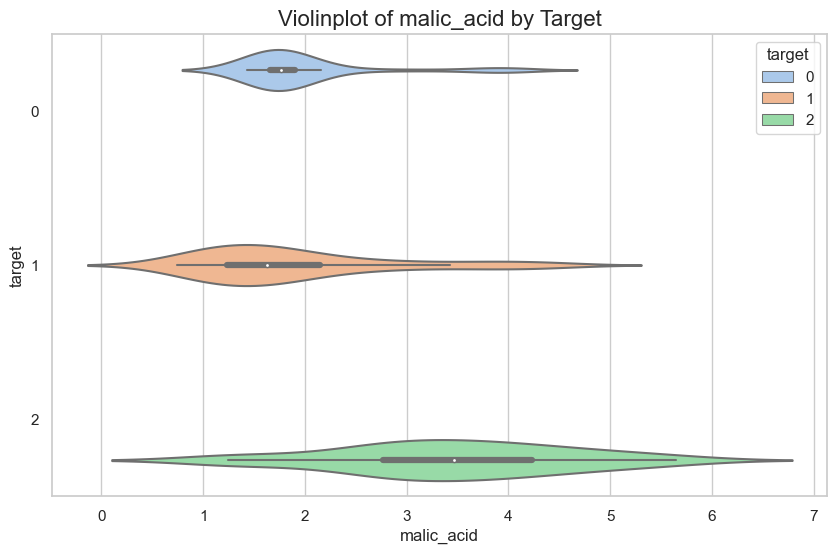

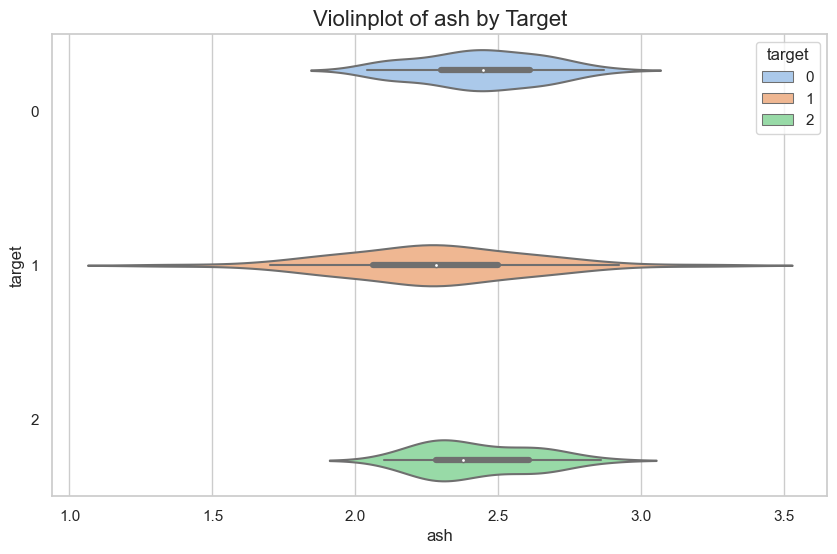

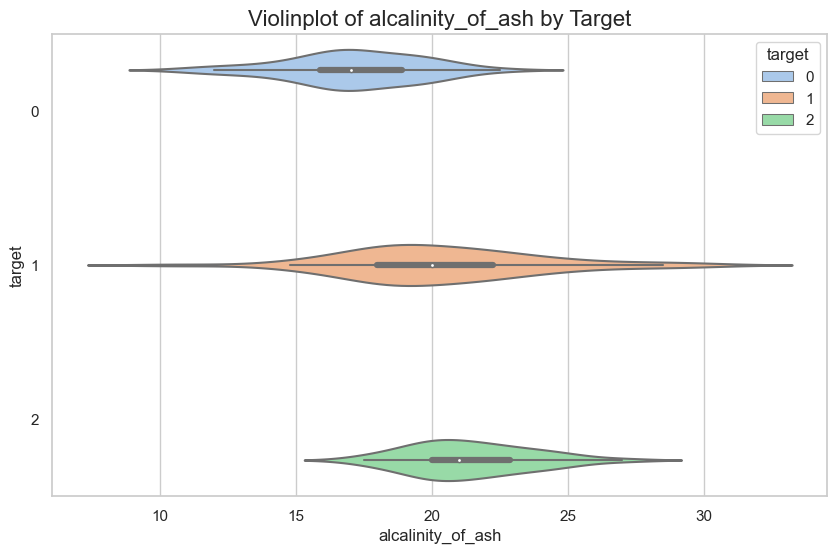

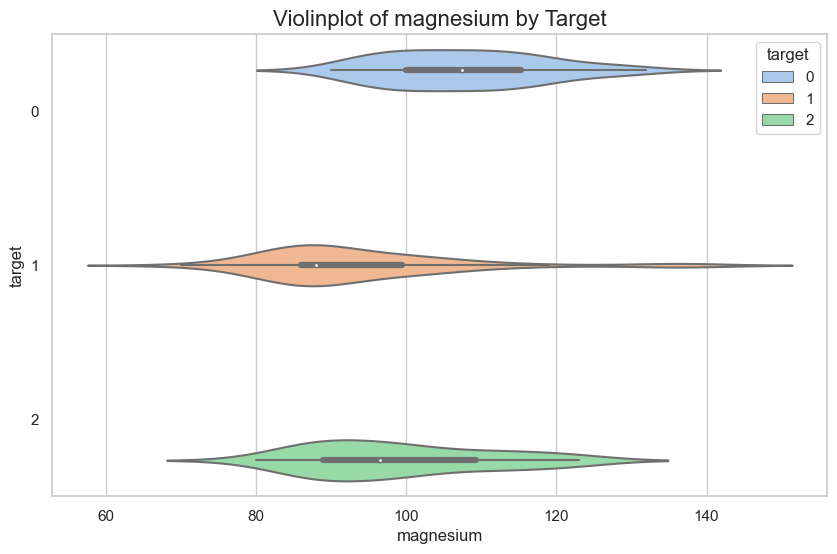

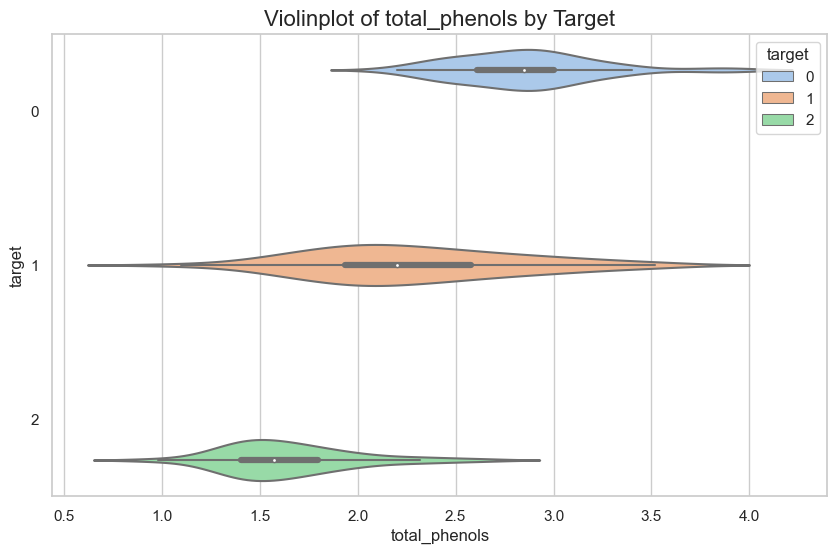

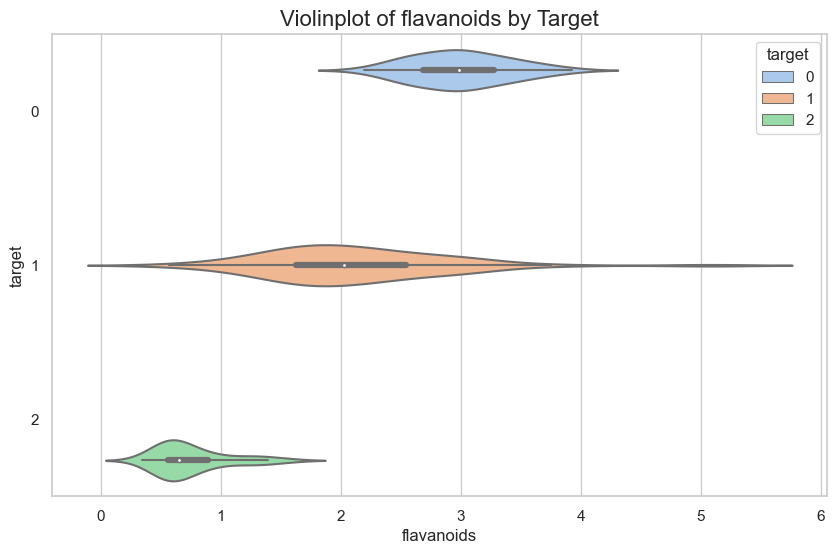

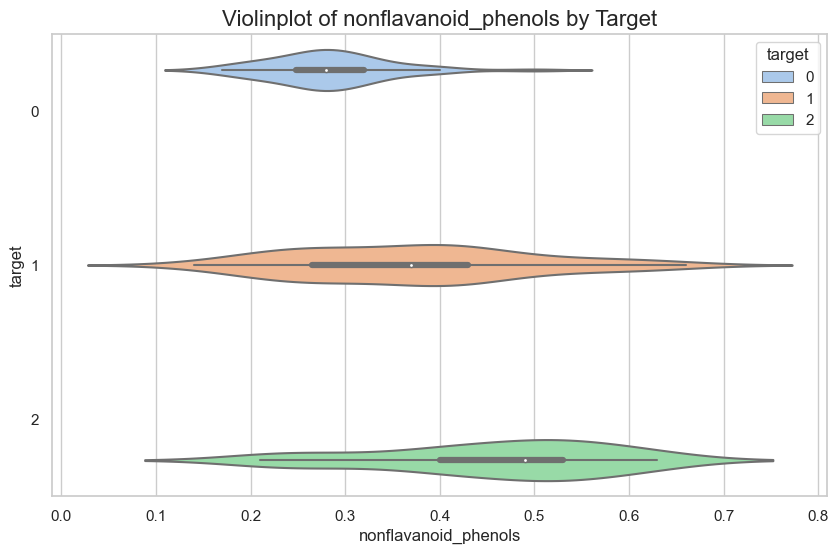

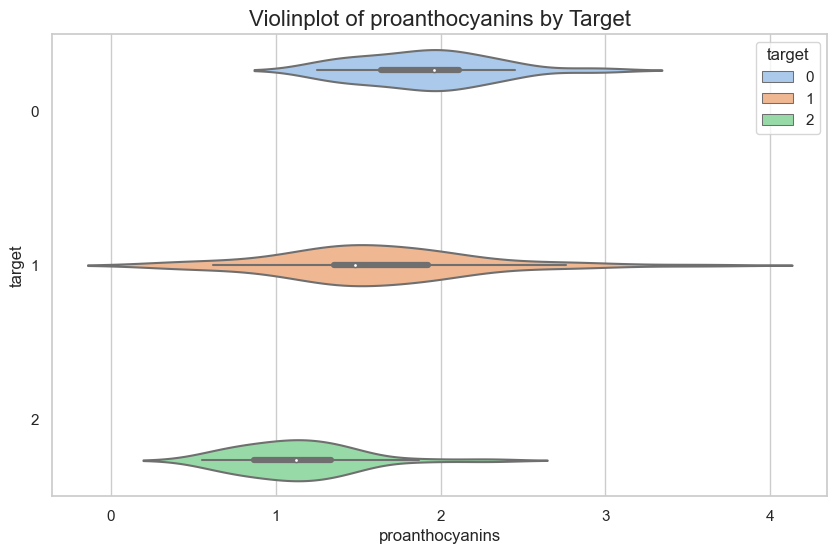

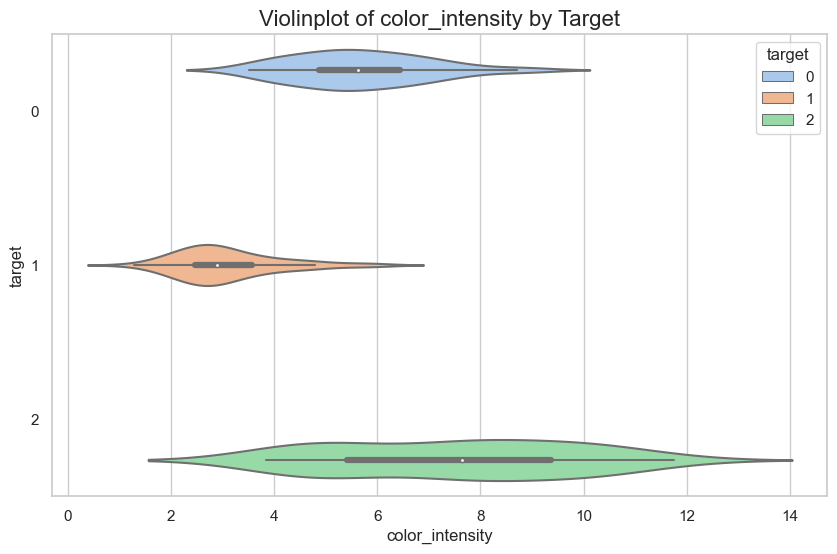

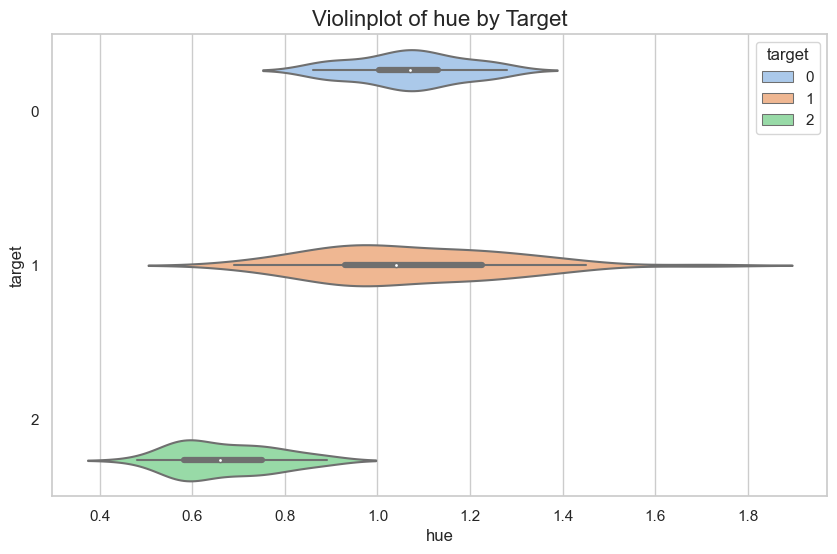

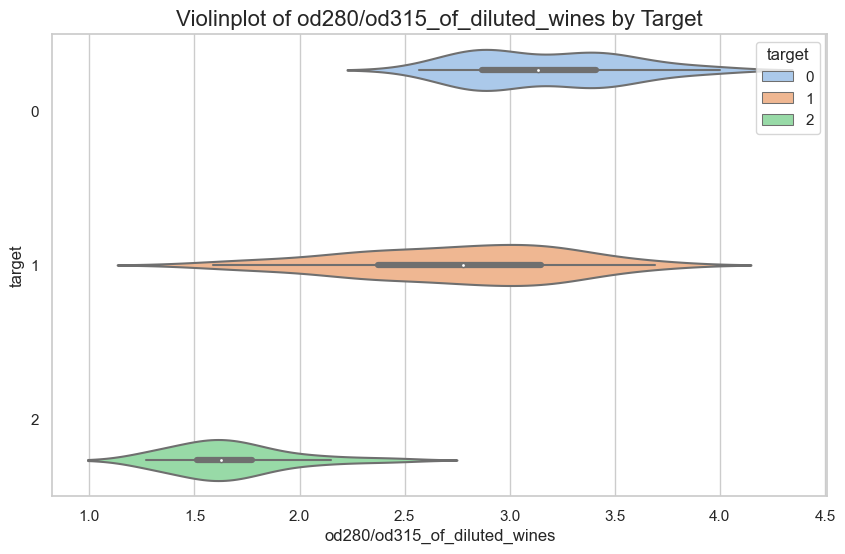

In [21]:
# let's look at the violinplot of each variable differentiating by the target variables in order to see if the distributions are different


sns.set(style="whitegrid")

for i in range(0, 12):
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=train, x=train.columns[i], y=train.columns[13], hue="target", palette="pastel"
    )

    plt.title(f"Violinplot of {train.columns[i]} by Target", fontsize=16)

    plt.show()

**Actually, the distribution of each variable appears almost always partially different if we distinguish the target variable.**

**In general almost all variables have a higher range for class 1 and a lower range for class 2.**

**The narrower range, in general, for class 2 and, sometimes, for class 0 for some variables and their different distribution  in terms of assumed values (see "od280/od315_of_diluted_wines", "total_phenols" and "flavanoids" variables) seems to make these two classes more separated.**

**However, Violinplots separated by target do not allow us to reach conclusions relevant to our classification purpose. No variable considered individually seems to have a huge power to predict a specific class. It will take a combination of them.**

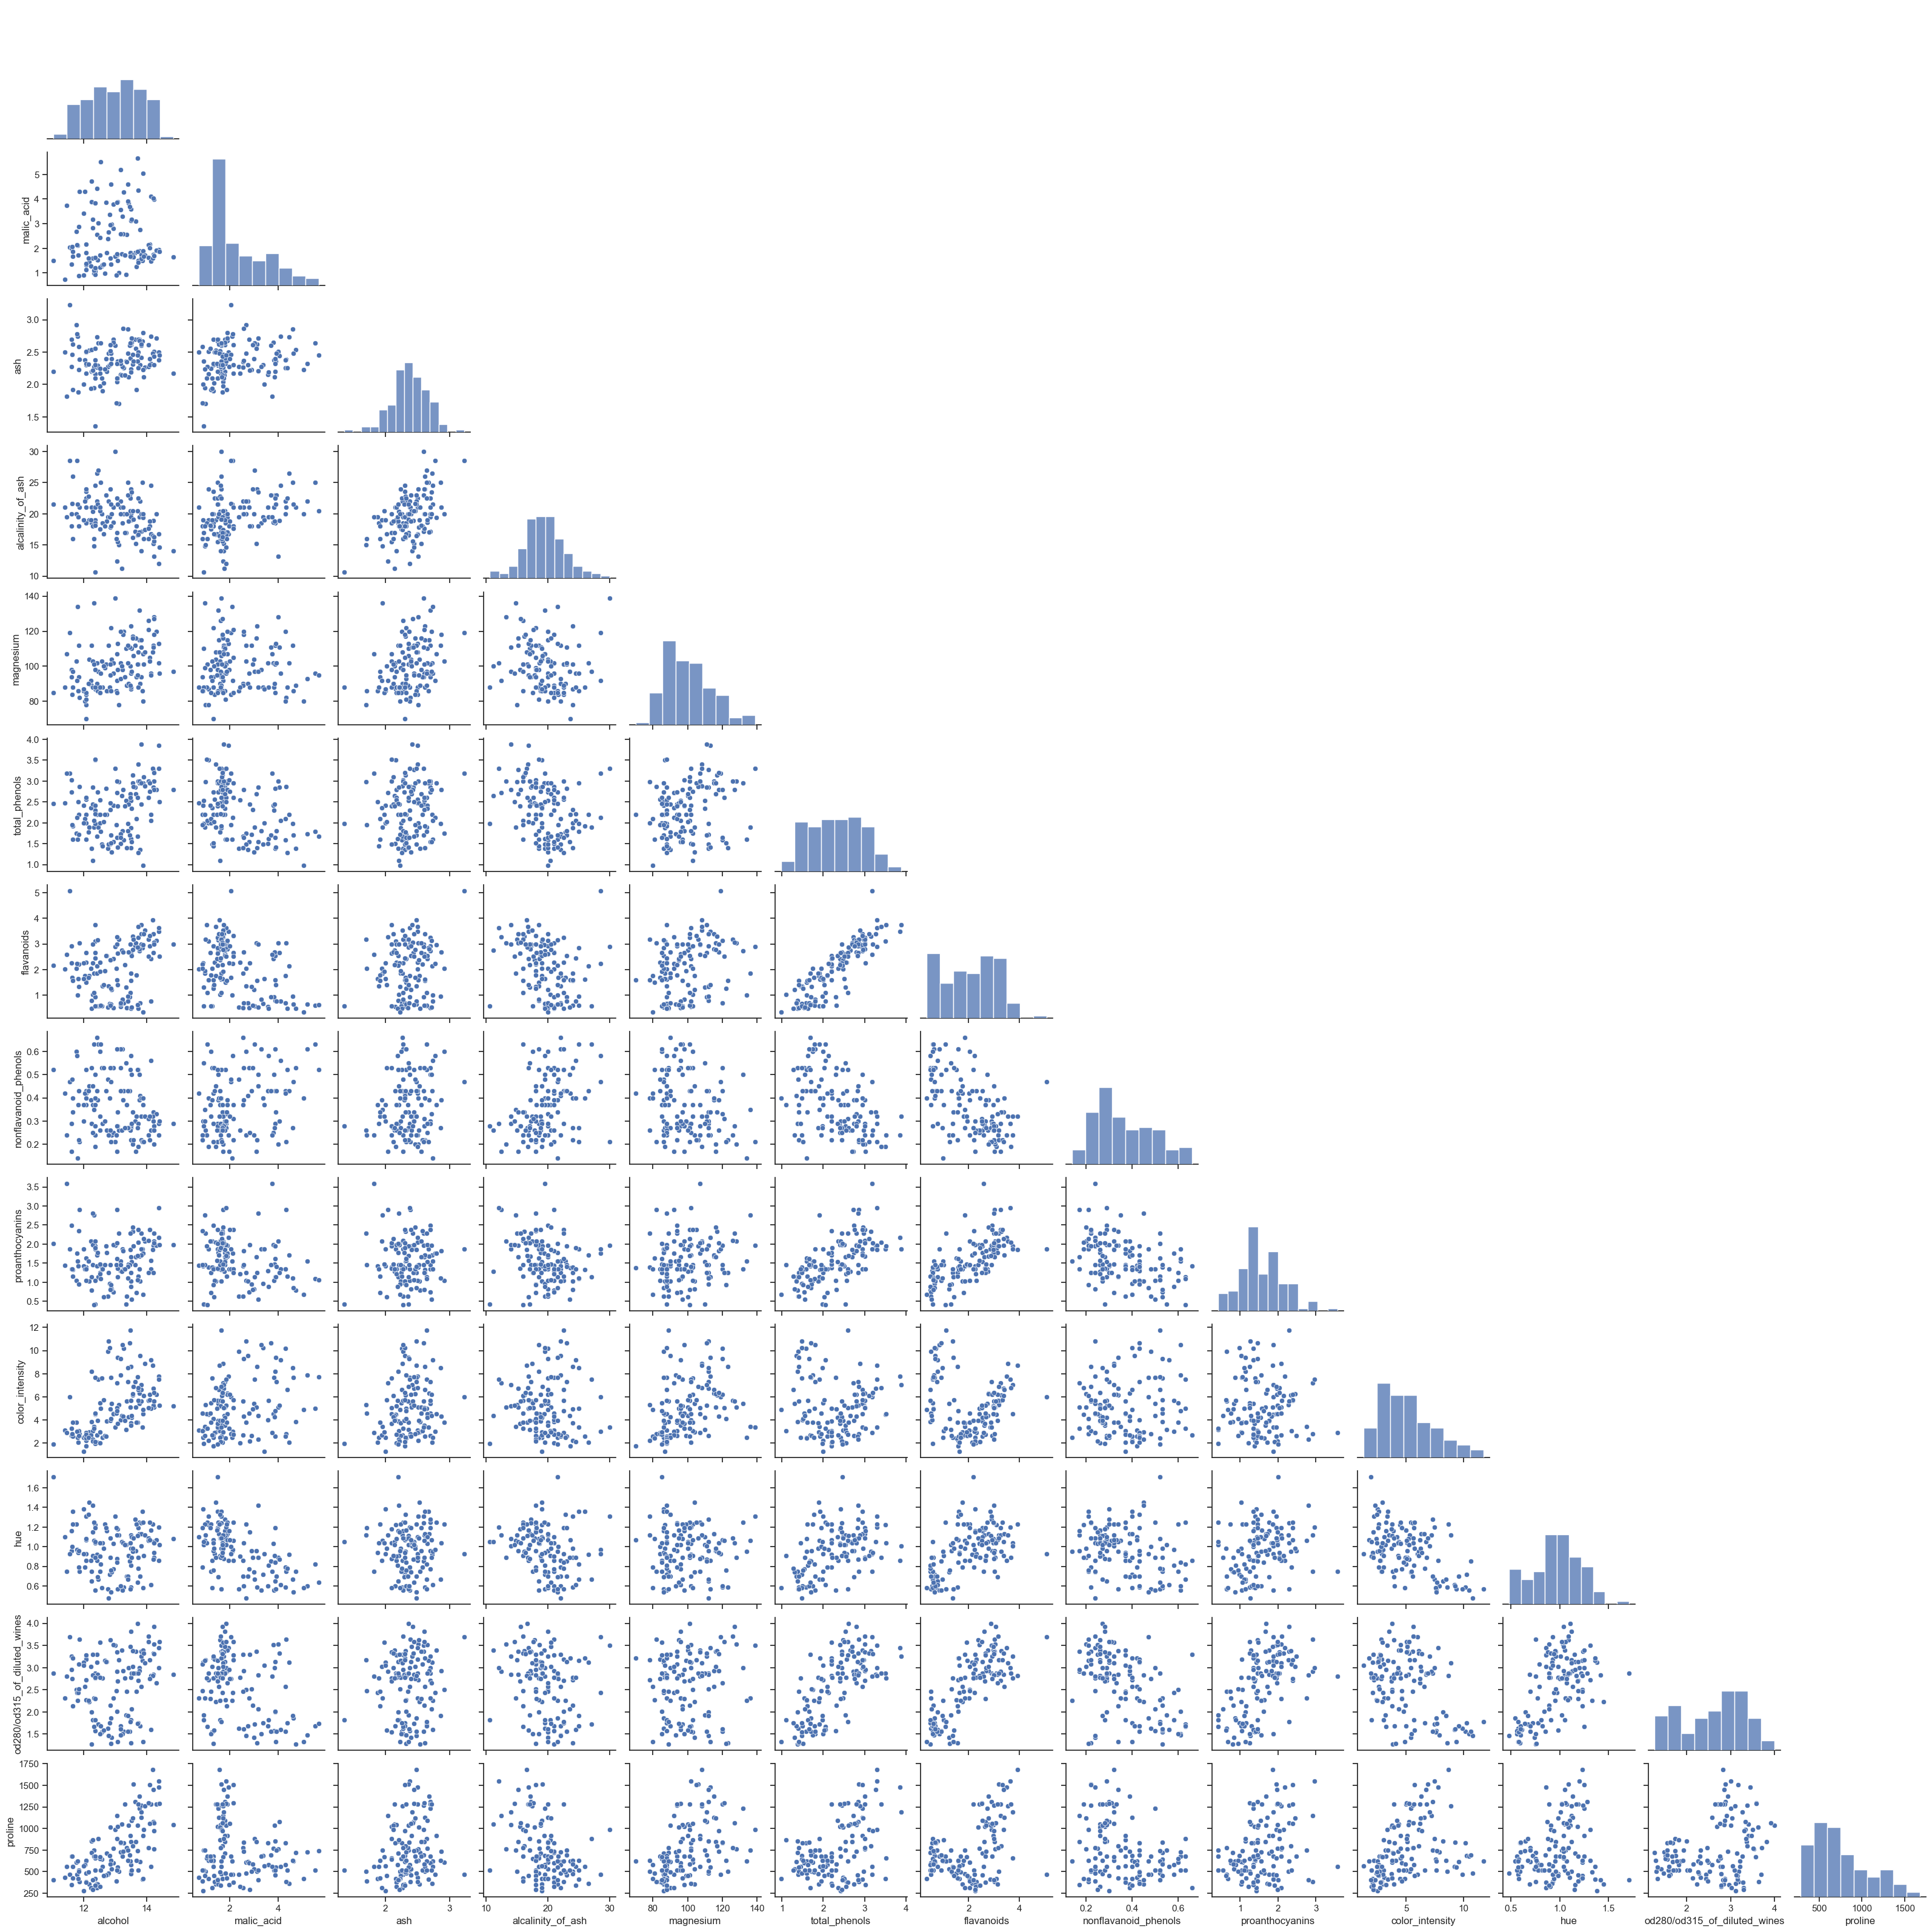

In [22]:
sns.set(style="ticks")

sns.pairplot(train, corner=True)

plt.show()

**The above graph show us some skewness distributions (see "magnesium" and "malic_acid" histograms).**

**When a variable is skewed some models may not work correctly. For example, distance-based models, like KNN Classifier, may encounter some difficulties. This is why there is a family of transformations that try to increase the symmetry of the variables, the power transformations. The practical suggestion provided in this case is to try to symmetrize the variables, check whether the transformation has improved the asymmetry and see if the performance of the model with the variables that obtained a significant improvement in asymmetry with the transformation increases compared to using the original variables.**<br> <br> <br> <br>



**The above graph show us also some (linear) correlated variables (see "flavanoids"-"total_phenols" and "flavanoids-od280/od315_of_diluted_wines" scatterplots).**

**Linear correlation between features (multicollinearity) in general doesn't improve models though they negatively affect specific models; in particular for linear models multicollinearity can yield solutions that are wildly varying and possibly numerically unstable. In that case we need to eliminate multicollinearity. The predictive power of a KNN Classifier, in general, is not negatively affected  by multicollinearity given that it isn't a linear model; however a strong linear correlation can be defined as a redundant information and it can negatively affect the efficiency of the model given that KNN is prone to slowness.**

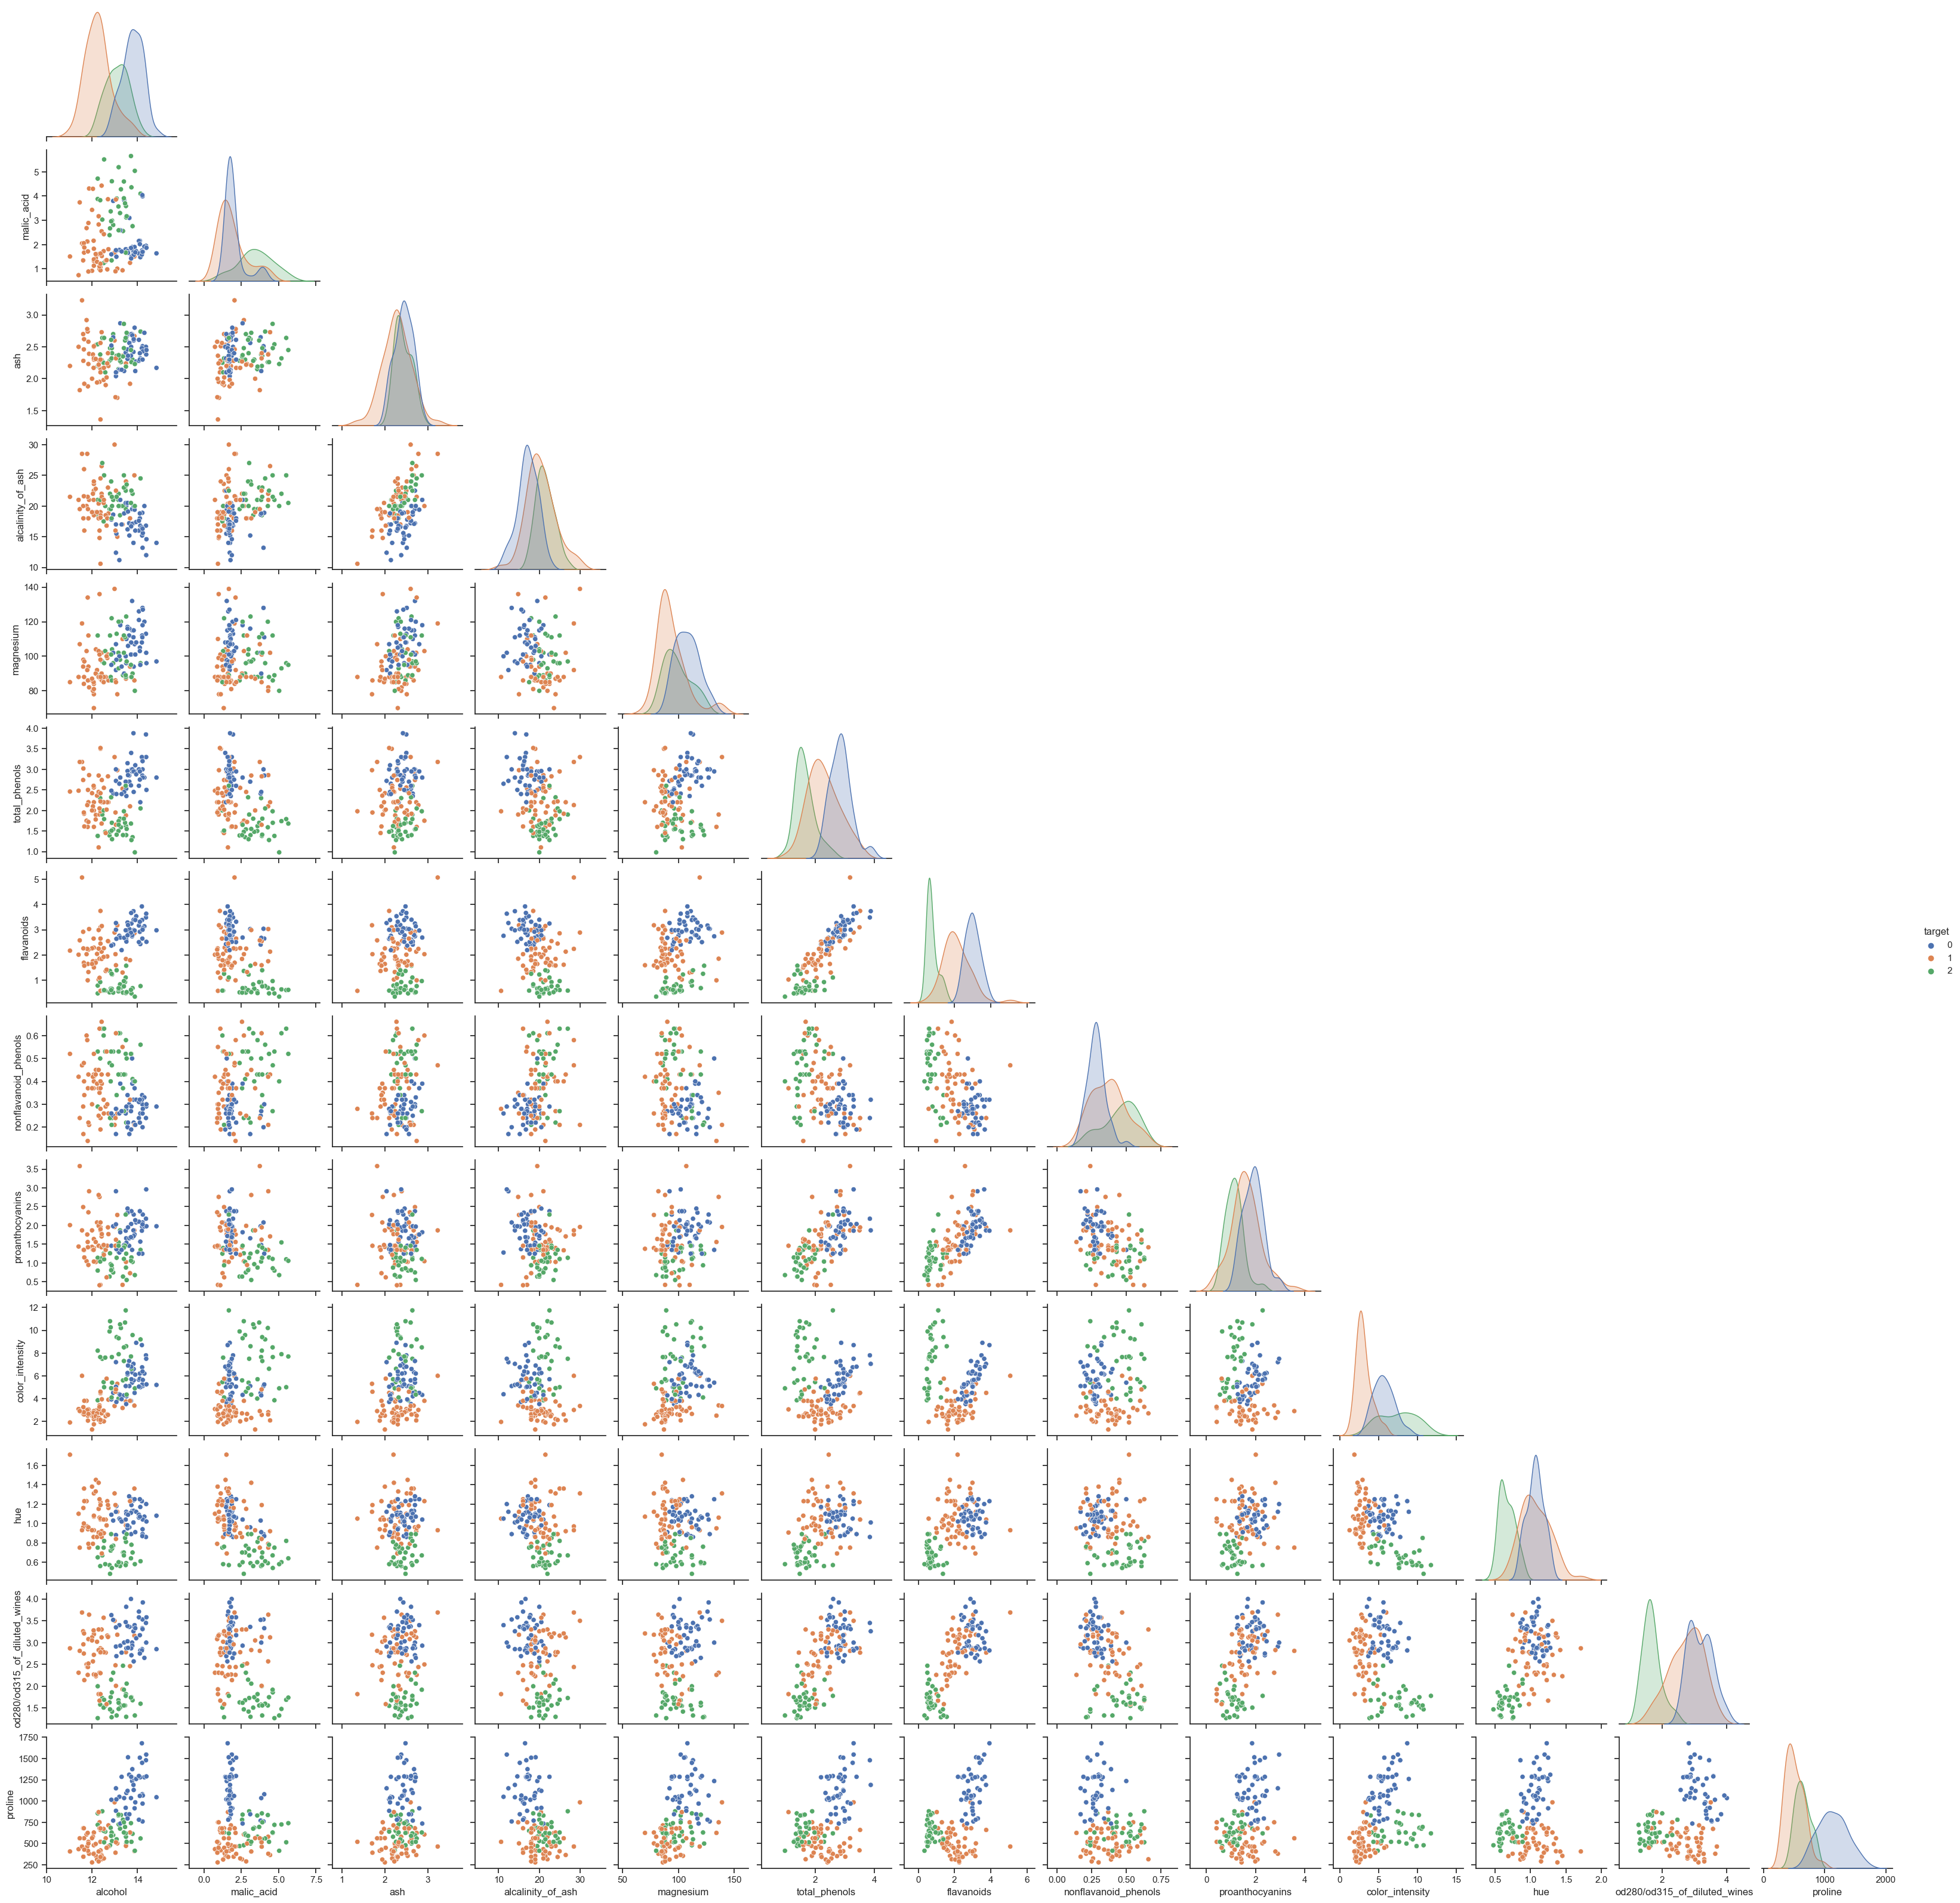

In [23]:
# let's have a look at the same plot considering the target

sns.set(style="ticks")

sns.pairplot(train, corner=True, hue="target")

plt.show()

**The above graph shows us some pairs of variables that do not appear capable of absolutely separating the three classes (see for example all pairs of variables with "ash" variable).**

**On the contrary, other pairs of variables (the most emblematic is the pair "proline"-"od280/od315_of_diluted_wines" scatterplot) appear to be able to separate the three classes quite well already in a two-dimensional space.**

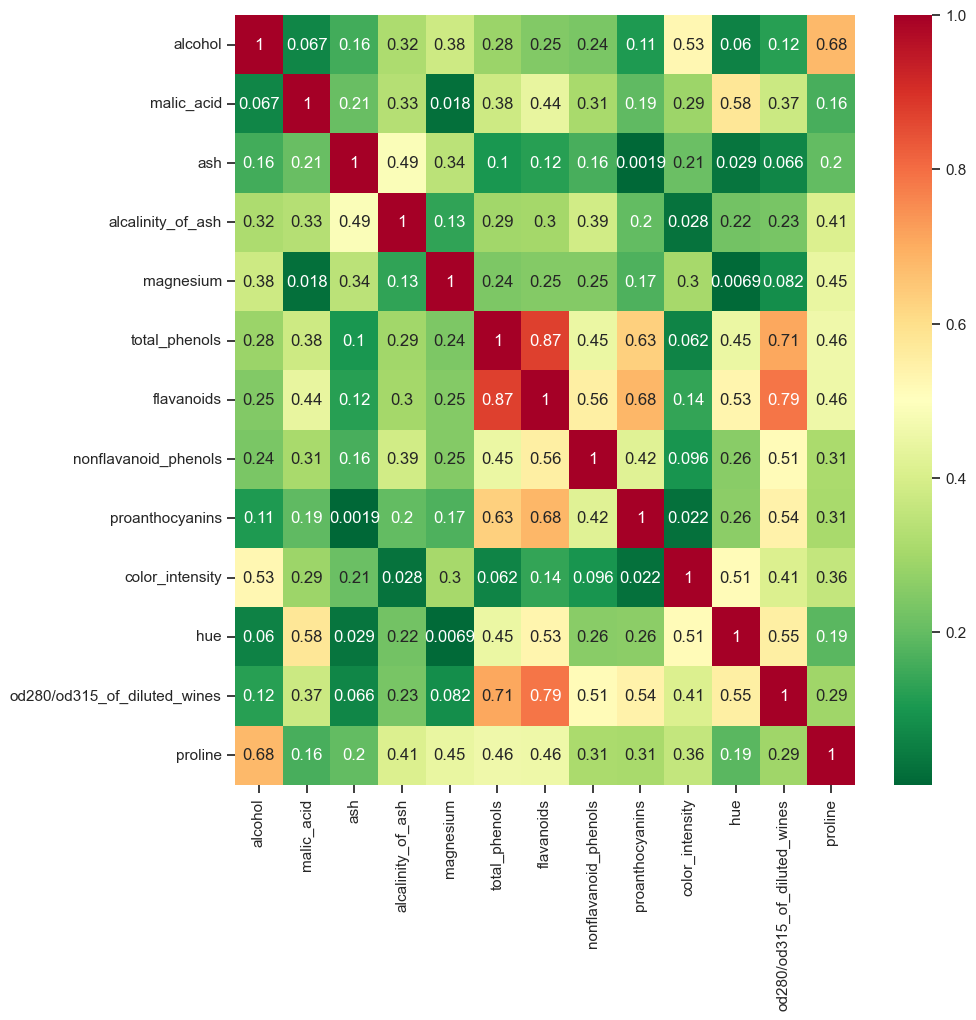

In [24]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.corr().abs(), cmap="RdYlGn_r", annot=True)
plt.show()

# "flavanoids" variable appears strongly linear correlated with "total_phenols" and "od280/od315_of_diluted_wines" variable.

**"flavanoids" variable appears strongly linear correlated with "total_phenols" and "od280/od315_of_diluted_wines" variable.**
**However, these three variables, as seen in the analysis of the violin plots, seem to be able to distinguish between class 0 and class 2**. 

**For this reason and given that the number of variables available is not high (therefore the model should not be excessively slow) we decide to keep these three variables although there may be some redundant information.**

*The Pearson Correlation Coefficient is based on three assumptions:*<br>
*1) The two variables need to be using a continuous scale;*<br>
*2) There should be no outliers;*<br>
*3) The variables should be normally or near-to-normally distributed.*<br>

The first assumption is satisfied by all variables, the second assumption is satisfied by some variables (see boxplot); for the third assumption we can do the Shapiro-Wilk test

In [25]:
# Let's check if variables passe the Shapiro-Wilk test.
# The null hypothesis (Ho) is that variable is normally distributed. 
# The alternative hypothesis (H1) is that variable is not normally distributed. 

shapiro_wilk_test(X_train)

# "flavanoids", "total_phenols", "od280/od315_of_diluted_wines"  don't have outliers but but did not pass the Shapiro-Wilk test.
# Since not all the assumptions are satisfied, the correlation coefficient (at least for these three variables) is not reliable

Reject the null hypothesis for column alcohol. The variable is not normally distributed
Reject the null hypothesis for column malic_acid. The variable is not normally distributed
Not enough evidence to reject the null hypothesis for ash.
Not enough evidence to reject the null hypothesis for alcalinity_of_ash.
Reject the null hypothesis for column magnesium. The variable is not normally distributed
Reject the null hypothesis for column total_phenols. The variable is not normally distributed
Reject the null hypothesis for column flavanoids. The variable is not normally distributed
Reject the null hypothesis for column nonflavanoid_phenols. The variable is not normally distributed
Not enough evidence to reject the null hypothesis for proanthocyanins.
Reject the null hypothesis for column color_intensity. The variable is not normally distributed
Not enough evidence to reject the null hypothesis for hue.
Reject the null hypothesis for column od280/od315_of_diluted_wines. The variable is not

In [26]:
# With the one-way ANOVA test we can verify presence of correlation between numerical variable and categorical variable.

# The null hypothesis (Ho) is that there is not a significant difference in mean. 
# The alternative hypothesis (H1) is that there is a significant difference in mean.

anova_correlation(X_train, y_train)

# Almost all variables are correlated with target variable.

Reject the null hypothesis for column alcohol. There is a significant difference in means.
Reject the null hypothesis for column malic_acid. There is a significant difference in means.
Reject the null hypothesis for column ash. There is a significant difference in means.
Reject the null hypothesis for column alcalinity_of_ash. There is a significant difference in means.
Reject the null hypothesis for column magnesium. There is a significant difference in means.
Reject the null hypothesis for column total_phenols. There is a significant difference in means.
Reject the null hypothesis for column flavanoids. There is a significant difference in means.
Reject the null hypothesis for column nonflavanoid_phenols. There is a significant difference in means.
Reject the null hypothesis for column proanthocyanins. There is a significant difference in means.
Reject the null hypothesis for column color_intensity. There is a significant difference in means.
No sufficient evidence to reject the null

**the "hue" variable does not appear to be correlated with the target variable.**

**From the violin plot, the distribution of this distinct variable for the target classes seems to partially confirm this absence of correlation.**

**However, from the second pairplot some variables combined with "hue" variable seem to separate reasonably well. This observation, combined with the reduced number of features, leads to conserving this variable.**

*The one-way ANOVA tests is based on three assumptions:*<br>
*1) The samples are independent;*<br>
*2) Each sample is from a normally distributed population;*<br>
*3) The population standard deviations of the groups are all equal. This property is known as homoscedasticity.*<br>

The first assumption is satisfied, the second assumption is satisfied by some variables (see Shapiro-Wilk test); for the third assumption we can do the Levene test

In [27]:
# The null hypothesis (Ho) is that Homoschedasticity is met. 
# The alternative hypothesis (H1) is that Homoschedasticity is not met.

check_homoscedasticity(X_train, y_train)

# "hue" variable passes the Shapiro-Wilk test but doesn't pass the Levene Test.
# Since not all the assumptions are respected, the ANOVA test (at least for hue variable) is not reliable

Reject the null hypothesis for alcohol. Homoscedasticity assumption is violated.
Reject the null hypothesis for malic_acid. Homoscedasticity assumption is violated.
Reject the null hypothesis for ash. Homoscedasticity assumption is violated.
Reject the null hypothesis for alcalinity_of_ash. Homoscedasticity assumption is violated.
Reject the null hypothesis for magnesium. Homoscedasticity assumption is violated.
Not enough evidence to reject the null hypothesis for total_phenols. Homoscedasticity assumption is met.
Reject the null hypothesis for flavanoids. Homoscedasticity assumption is violated.
Reject the null hypothesis for nonflavanoid_phenols. Homoscedasticity assumption is violated.
Reject the null hypothesis for proanthocyanins. Homoscedasticity assumption is violated.
Reject the null hypothesis for color_intensity. Homoscedasticity assumption is violated.
Reject the null hypothesis for hue. Homoscedasticity assumption is violated.
Not enough evidence to reject the null hypothe

# PRE-PROCESSING

Through EDA we discovered that we could obtain margins for improvement by considering three elements:<br>
1) Outlier management; <br>
2) Scaling; <br>
3) Power transformation <br>


Let's see possible improvement one by one separately

### Outlier management

What happen if we eliminate outliers?

In [28]:
knn = KNeighborsClassifier(n_jobs=-1) # n_jobs cannot be considered as a real hyperparameter (it doesn’t affect fit method)
knn.fit(X_train_nooutliers, y_train_nooutliers)
knn.score(X_test, y_test).round(2)

0.58

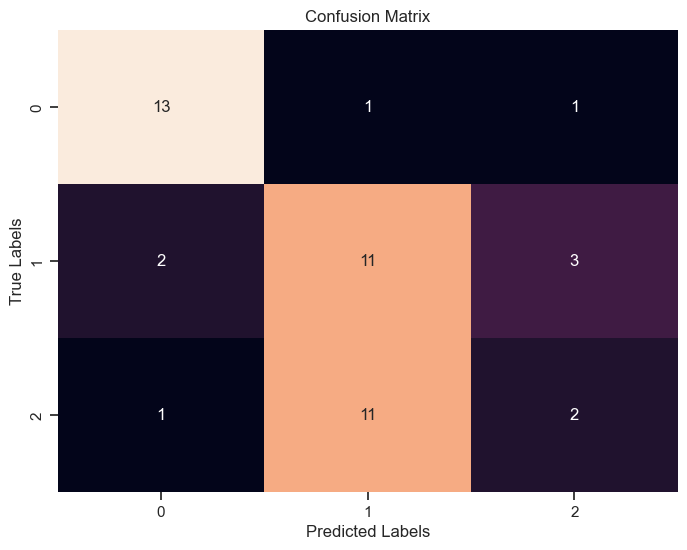

In [29]:
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

**If we eliminate outliers model doesn't improve. Performances are the same of the baseline model.**

### Scaling
What happen if we scale variable?

In [30]:
knn = KNeighborsClassifier(n_jobs=-1) # n_jobs cannot be considered as a real hyperparameter (it doesn’t affect fit method)
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test).round(2)

0.96

**If we scale variables model has a huge improvement. The model is almost perfect.**

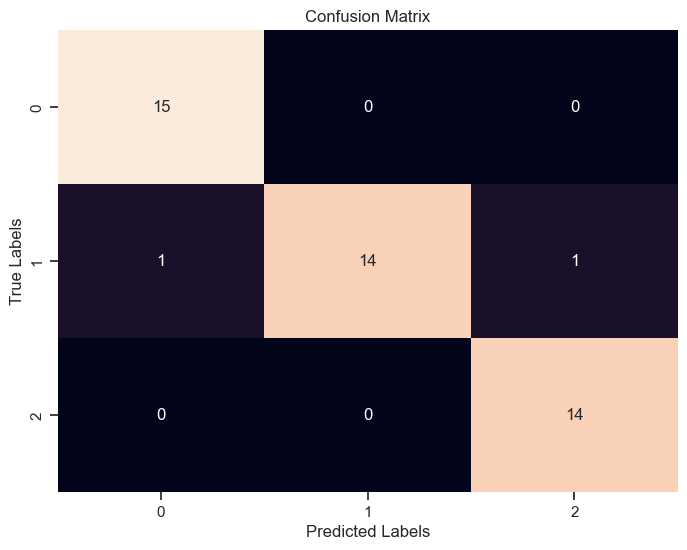

In [31]:
y_pred = knn.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Power Transformation
What happen if we apply Power Transformation?

In [32]:
evaluate_skewness(X_train.iloc[:, 0:13])

Variable  Skewness               Evaluation
0                        alcohol -0.082784  Approximately symmetric
1                     malic_acid  0.951767        Moderately skewed
2                            ash -0.310023  Approximately symmetric
3              alcalinity_of_ash  0.230730  Approximately symmetric
4                      magnesium  0.617181        Moderately skewed
5                  total_phenols  0.098291  Approximately symmetric
6                     flavanoids  0.011587  Approximately symmetric
7           nonflavanoid_phenols  0.487024  Approximately symmetric
8                proanthocyanins  0.420130  Approximately symmetric
9                color_intensity  0.725130        Moderately skewed
10                           hue  0.023410  Approximately symmetric
11  od280/od315_of_diluted_wines -0.284025  Approximately symmetric
12                       proline  0.793283        Moderately skewed

**As we noticed from the first pair plot, some variables are asymmetric. Now let's check if a power transformation changes the asymmetry of the variables strongly skewed and moderately skewed. The idea is to keep transformed only those variables whose power transformation allows a significant reduction in skewness.**

In [33]:
skewness_df = evaluate_skewness(X_train.iloc[:, 0:13])

transformed_skewness_df = apply_power_transformation(skewness_df, X_train.iloc[:, 0:13])

transformed_skewness_df

Variable  Skewness_before_pt  Skewness_after_pt  \
0       malic_acid            0.951767           0.074821   
1        magnesium            0.617181           0.020197   
2  color_intensity            0.725130           0.005176   
3          proline            0.793283           0.012376   

                Evaluation  
0  Approximately symmetric  
1  Approximately symmetric  
2  Approximately symmetric  
3  Approximately symmetric

**All variables that were strongly skewed and moderately skewed with the power transformation have become approximately symmetric. Therefore, in the model evaluation phase we will consider all the variables before the power transformation are strongly skewed and moderately skewed.**

In [34]:
pt = PowerTransformer()

columns_to_transform = ['malic_acid', 'magnesium', 'color_intensity', 'proline']

data_to_transform_train = X_train[columns_to_transform]
transformed_data_train = pt.fit_transform(data_to_transform_train)
X_train_transformed = X_train.copy()
X_train_transformed[columns_to_transform] = transformed_data_train


data_to_transform_test = X_test[columns_to_transform]
transformed_data_test = pt.transform(data_to_transform_test)
X_test_transformed = X_test.copy()
X_test_transformed[columns_to_transform] = transformed_data_test

In [35]:
knn = KNeighborsClassifier(n_jobs=-1) # n_jobs cannot be considered as a real hyperparameter (it doesn’t affect fit method)
knn.fit(X_train_transformed, y_train)
knn.score(X_test_transformed, y_test).round(2)

0.96

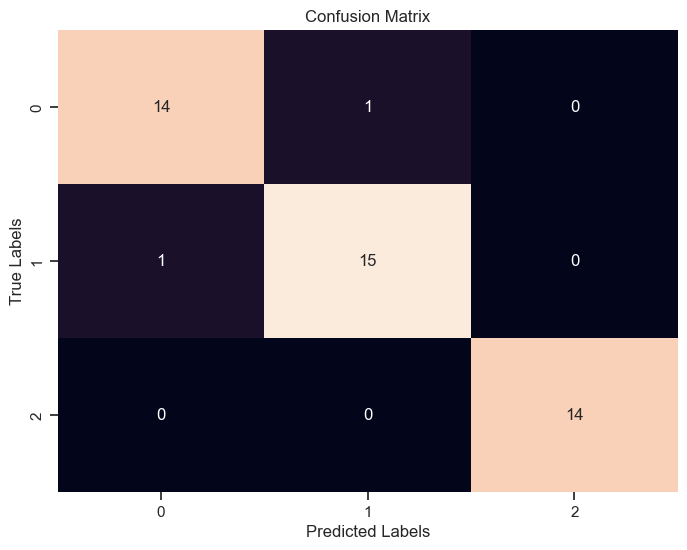

In [36]:
y_pred = knn.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

** Like the model with scaling also model with power transformation has a huge improvement. The model is almost perfect.**

**The interesting result is that compared to the baseline model in which class 2 was the most problematic class, now its predictions are perfect as can also be seen from the classification report**

In [37]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.94      0.94      0.94        16
           2       1.00      1.00      1.00        14

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



**Now that we have seen how the removal of outliers alone does not bring any improvement, while scaling and power transformation do (and a lot) let's check what happens if we combine the two transformations.**

In [38]:
preprocessor_X_train = create_preprocessor(X_train)
X_train_transformed = preprocessor_X_train.fit_transform(X_train)
X_test_transformed = preprocessor_X_train.transform(X_test)

In [39]:
knn.fit(X_train_transformed, y_train)
knn.score(X_test_transformed, y_test).round(2)

0.96

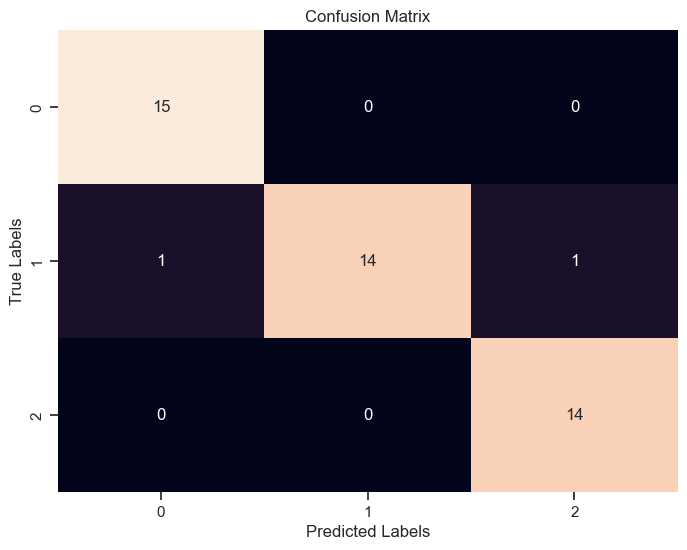

In [40]:
y_pred = knn.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

**Combining power transformation with scaling gives the same results as applying scaling alone.**

**In light of these results we will try to do hyper-parameter tuning in the model that only applies scaling. We want verify if we can further improve performance**

**Given the extremely small dataset in terms of rows and columns and given the relatively small number of hyperparameters we consider a leave-one-out cross validation strategy associated to a GridSearchCV for hyper parameter tuning. The hyperparameters we consider are n_neighbors, weights, alghoritm and metric which are the most important:**<br>

1) Given the low number of rows in the training set a range between 1 and 30 for n_neighbors I believe is an optimal set of numbers to explore for a first time;<br>
2) We explore the all type of weights inside the knn class in sklearn;<br>
3) We explore the all type of alghoritm inside the knn class in sklearn;<br>
4) We explore a huge type of distance.<br> <br> <br>


In [41]:
preprocessor = create_preprocessor(X_train, apply_yeo_johnson=False)

# Creazione del classificatore KNN
knn = KNeighborsClassifier()

# Creazione della pipeline con preprocessore e classificatore
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", knn)
])

# Definizione del parametro grid
param_grid = {
    "classifier__n_neighbors": range(1, 30),
    "classifier__weights": ["uniform", "distance"],
    "classifier__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "classifier__metric": [
        "euclidean",
        "manhattan",
        "chebyshev",
        "minkowski",
        "hamming",
        "canberra",
        "braycurtis",
        "cosine",
    ],
}


loo = LeaveOneOut()


grid_search = GridSearchCV(pipeline, param_grid, cv=loo, n_jobs=-1)


grid_search.fit(X_train, y_train)

# Stampiamo i migliori parametri trovati
print("Best parameters:")
print(grid_search.best_params_)




Best parameters:
{'classifier__algorithm': 'auto', 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}


In [42]:
knn = KNeighborsClassifier(n_jobs=-1, algorithm="auto", metric="euclidean", n_neighbors=11, weights="uniform")
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test).round(2)

0.96

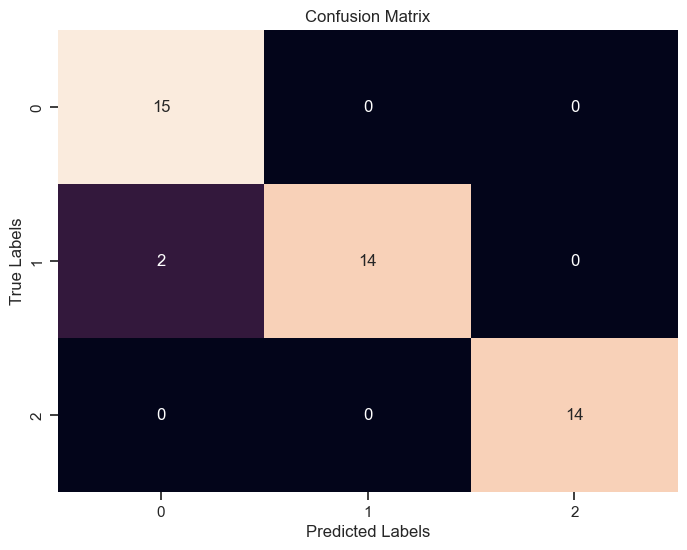

In [43]:
y_pred = knn.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [44]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.88      0.93        16
           2       1.00      1.00      1.00        14

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



# CONCLUSIONS

**We applied various pre-processing procedures and chose the one that only involved scaling.**

**Based on this model we did hyperparameter tuning with the hope of having even better results than the default values.**

**Although the accuracy has not changed the "error distribution" has changed slightly.**

**Not having a good knowledge domain, we don't know how important the different distribution of errors could be. In other words, not knowing whether the ability to predict class 0 or class 1 or class 2 well could be more serious, for us the 2 models could be indifferent (even if in fact the hyperparameter tuning caused a waste of time , which turned out to be potentially useless).**